In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cpi

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
raw_data = pd.read_csv('/Users/charlizesamuels/Downloads/acquisitions_update_2021.csv')
print(raw_data.shape[0])
print(raw_data.head())

1455
   ID Parent Company Acquisition Year Acquisition Month  \
0   1          Apple             1988               Mar   
1   2          Apple             1988               Jun   
2   3          Apple             1988               Jun   
3   4          Apple             1988               Jul   
4   5          Apple             1989               Jan   

        Acquired Company           Business Country Acquisition Price  \
0    Network Innovations           Software       -                 -   
1  Orion Network Systems  Computer Software       -                 -   
2              Styleware  Computer software       -                 -   
3        Nashoba Systems  Computer software       -                 -   
4         Coral Software  Computer software       -                 -   

  Category Derived Products  
0        -                -  
1        -                -  
2        -                -  
3        -                -  
4        -                -  


In [3]:
to_drop = ['Acquisition Month', 'Category', 'Derived Products']
raw_data = raw_data.drop(to_drop, axis=1)  # Specify axis=1 to drop columns
raw_data.head()


,ID,Parent Company,Acquisition Year,Acquired Company,Business,Country,Acquisition Price
0,1,Apple,1988,Network Innovations,Software,-,-
1,2,Apple,1988,Orion Network Systems,Computer Software,-,-
2,3,Apple,1988,Styleware,Computer software,-,-
3,4,Apple,1988,Nashoba Systems,Computer software,-,-
4,5,Apple,1989,Coral Software,Computer software,-,-


In [4]:
# Filtering out rows with '-'
data = raw_data[raw_data['Business'] != '-']
data = data[data['Acquisition Price'] != '-']
data = data[data['Acquisition Year'] != '-']
data = data[data['Country'] != '-']
data = data[data['Acquisition Price'] != 'undisclosed']
# Convert Acquisition Price to numeric
data['Acquisition Price'] = pd.to_numeric(data['Acquisition Price'], errors='coerce')

# Convert Acquisition Year to integer
data['Acquisition Year'] = pd.to_numeric(data['Acquisition Year'], errors='coerce', downcast='integer')

# Drop rows with NaN values
data = data.dropna(subset=['Acquisition Price', 'Acquisition Year'])

# Adjust for inflation to a reference year (e.g., 2023)
data['Adjusted_Acquisition_Price'] = data.apply(
    lambda row: cpi.inflate(row['Acquisition Price'], row['Acquisition Year'], to=2023),
    axis=1
)

# Remove remaining companies to solely look at IBM
data = data[data['Parent Company'] != 'Twitter']
unique_companies = data['Parent Company'].unique()
print(unique_companies)
print(data.shape[0])

['Ibm']
38


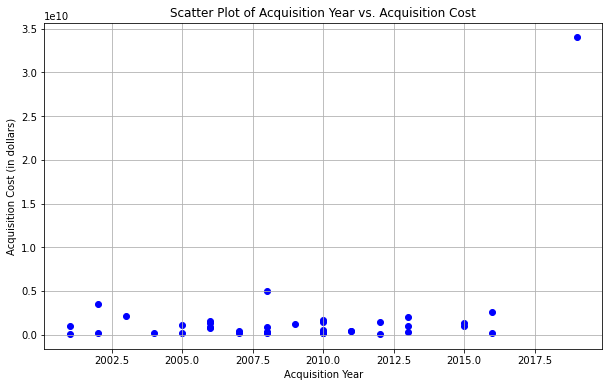

In [5]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(data['Acquisition Year'], data['Acquisition Price'], color='blue')

# Adding labels and title
plt.title('Scatter Plot of Acquisition Year vs. Acquisition Cost')
plt.xlabel('Acquisition Year')
plt.ylabel('Acquisition Cost (in dollars)')
plt.grid(True)

# Show the plot
plt.show()

In [6]:
# Get the frequency count of each company
country_counts = data['Country'].value_counts()

# Calculate the proportion
country_proportions = country_counts / len(data)

# Display the proportions
print(country_proportions)

United States    0.710526
Canada           0.105263
Israel           0.078947
India            0.026316
Switzerland      0.026316
Sweden           0.026316
France           0.026316
Name: Country, dtype: float64


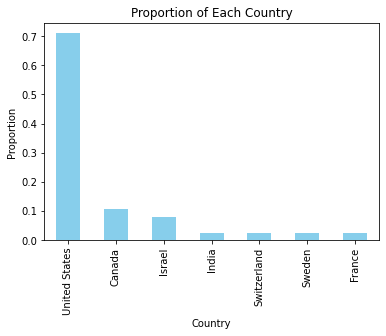

In [7]:
country_proportions.plot(kind='bar', color='skyblue')
plt.title('Proportion of Each Country')
plt.xlabel('Country')
plt.ylabel('Proportion')
plt.show()

In [8]:
# Get the frequency count of each company
business_counts = data['Business'].value_counts()

# Calculate the proportion
business_proportions = business_counts / len(data)

# Display the proportions
print(business_proportions)

Business strategy consulting                                       0.026316
Software Development Firm                                          0.026316
Business software integration                                      0.026316
Data Compression                                                   0.026316
Marketing planning software                                        0.026316
Data warehousing and analytics                                     0.026316
Financial governance                                               0.026316
Risk Management                                                    0.026316
Cloud-based Retail Analytics                                       0.026316
Human Capital Solutions                                            0.026316
Database software                                                  0.026316
Cloud Computing Infrastructure                                     0.026316
Cyber Security                                                     0.026316
Mobile Devic

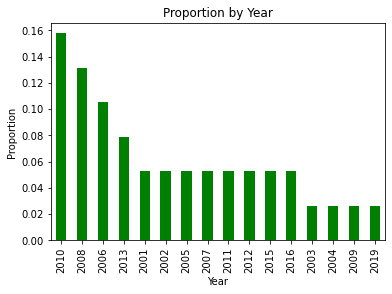

In [9]:
# Get the frequency count of each company
year_counts = data['Acquisition Year'].value_counts()

# Calculate the proportion
year_proportions = year_counts / len(data)

year_proportions.plot(kind='bar', color='green')
plt.title('Proportion by Year')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.show()

Decision Tree Cross-Validation MSE: 6.1269251481520325e+19
Decision Tree Test MSE: 4.1533223306152346e+19
Random Forest Cross-Validation MSE: 4.240090495468384e+19
Random Forest Test MSE: 2.0930596738679685e+19


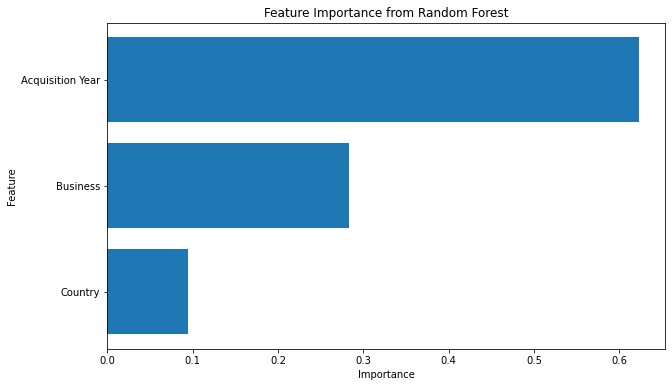

In [10]:
# Data Preprocessing
# Encode categorical variables (Country and Business) using LabelEncoder
label_encoder_country = LabelEncoder()
label_encoder_business = LabelEncoder()

data['Country'] = label_encoder_country.fit_transform(data['Country'])
data['Business'] = label_encoder_business.fit_transform(data['Business'])

# Define features (X) and target (y)
X = data[['Country', 'Business', 'Acquisition Year']]
y = data['Acquisition Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Pre-Pruning
decision_tree = DecisionTreeRegressor(
    max_depth=4,          # Limit tree depth to prevent overfitting
    min_samples_split=4,  # Minimum samples required to split a node
    min_samples_leaf=2,   # Minimum samples required at each leaf node
    random_state=42
)

# Training the model
decision_tree.fit(X_train, y_train)

# Evaluate the Decision Tree using cross-validation
cv_scores = cross_val_score(decision_tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Decision Tree Cross-Validation MSE: {-cv_scores.mean()}")

# Predict on the test set and evaluate
y_pred_tree = decision_tree.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree Test MSE: {mse_tree}")

# 2. Inclusion of Random Forest (Ensemble Method)
random_forest = RandomForestRegressor(
    n_estimators=100,     # Number of trees in the forest
    max_depth=4,          # Control the depth of each tree
    min_samples_split=4,  # Minimum samples required to split a node
    min_samples_leaf=2,   # Minimum samples required at each leaf node
    random_state=42
)

# Train the Random Forest
random_forest.fit(X_train, y_train)

# Evaluate the Random Forest using cross-validation
cv_scores_rf = cross_val_score(random_forest, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Random Forest Cross-Validation MSE: {-cv_scores_rf.mean()}")

# Predict on the test set and evaluate
y_pred_rf = random_forest.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Test MSE: {mse_rf}")

# Feature Importance from the Random Forest
plt.figure(figsize=(10, 6))
plt.barh(X.columns, random_forest.feature_importances_)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()